# 정형 데이터와 함께 LLM 사용하기

데이터는 비정형 데이터, 정형 데이터, 반정형 데이터로 분류할 수 있다.

정형 데이터를 질의하려면 해당 데이터베이스의 기술에 특화된 언어/방법을 사용해야 한다.  
예를 들면 관계형 데이터베이스의 테이블에서 데이터를 추출하려면 SQL을 사용할 줄 알아야 한다.

그런데 정형 데이터에 관해 자연어로 질문하려면 어떻게 해야 할까?  
애플리케이션이 단순한 숫자 답변이 아니라 숫자에 대한 맥락까지 제공하는 대화형 답변을 제공할 수 있다면 어떨까?

이것이 바로 우리가 다음 절에서 LLM 기반 애플리케이션을 통해 달성하고자 하는 목표이다.

여기서는 관계형 데이터버이스를 바라보는 코파일럿 이라는 것을 구축해 보자.

이름을 DBCopilot 이라고 하겠다.

## 샘플 데이터베이스

https://github.com/lerocha/chinook-database/releases 참고

In [1]:
import sqlite3
import pandas as pd
## 데이터베이스에 연결
database = 'Chinook_Sqlite.sqlite'


conn = sqlite3.connect(database)

## 테이블 가져오기
tables = pd.read_sql("""SELECT name, type
                        FROM sqlite_master
                        WHERE type IN ("table", "view");""", conn)

tables

,name,type
0,Album,table
1,Artist,table
2,Customer,table
3,Employee,table
4,Genre,table
5,Invoice,table
6,InvoiceLine,table
7,MediaType,table
8,Playlist,table
9,PlaylistTrack,table


In [3]:
pd.read_sql("""PRAGMA table_info(customer);""",conn)

,cid,name,type,notnull,dflt_value,pk
0,0,CustomerId,INTEGER,1,None,1
1,1,FirstName,NVARCHAR(40),1,None,0
2,2,LastName,NVARCHAR(20),1,None,0
3,3,Company,NVARCHAR(80),0,None,0
4,4,Address,NVARCHAR(70),0,None,0
5,5,City,NVARCHAR(40),0,None,0
6,6,State,NVARCHAR(40),0,None,0
7,7,Country,NVARCHAR(40),0,None,0
8,8,PostalCode,NVARCHAR(10),0,None,0
9,9,Phone,NVARCHAR(24),0,None,0


In [5]:
pd.read_sql("""
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customer c
JOIN invoice i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;

""", conn)

,Country,Sales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48


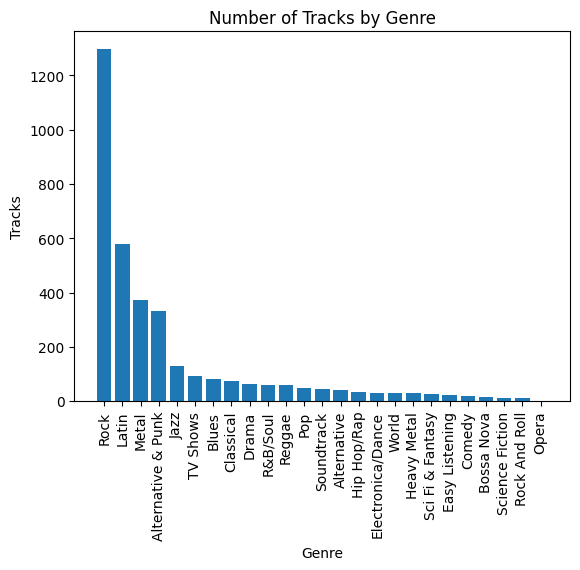

In [7]:
import matplotlib.pyplot as plt

# SQL 질의를 정의
sql = """
SELECT g.Name AS Genre, COUNT(t.TrackId) AS Track
FROM genre g
JOIN track t ON g.GenreId = t.GenreId
GROUP BY Genre
ORDER BY Track DESC;
"""

# 데이터프레임을 생성
data = pd.read_sql(sql, conn)

# Plot the data as a bar chart
plt.bar(data.Genre, data.Track)
plt.title("Number of Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Tracks")
plt.xticks(rotation=90)
plt.show()

## 랭체인 에이전트 및 SQL 에이전트

In [8]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

True

In [9]:
# 먼저 모든 구성 요소르 초기화하고 SQLDatabase 랭체인 구성 요소를 사용하여 DB에 대한 연결을 설정

from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

db = SQLDatabase.from_uri('sqlite:///Chinook_Sqlite.sqlite')

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
)

In [10]:
# 사용 가능한 도구 확인

[tool.name for tool in toolkit.get_tools()]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [11]:
# 간단한 쿼리로 에이전트를 실행해보자

agent_executor.invoke("playlist_track 테이블 구조를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, TrackThe relevant table for the question is "PlaylistTrack." I will now query the schema of this table to provide its structure in Korean.

Action: sql_db_schema  
Action Input: "PlaylistTrack"  
CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId")
)

/*
3 rows from PlaylistTrack table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/I can now summarize the structure of the "PlaylistTrack" table in Korean.

Final Answer: "PlaylistTrack" 테이블의 구조는 다음과 같습니다:
- PlaylistId (정수, NOT NULL)
- TrackId (정수, NOT NULL)
- 기본 키: (PlaylistId, TrackId)
- 외래 키: TrackId는 Track 테이블의 TrackId를 참조하고, PlaylistId는 Playlist 테이블의

{'input': 'playlist_track 테이블 구조를 한국어로 알려줘',
 'output': '"PlaylistTrack" 테이블의 구조는 다음과 같습니다:\n- PlaylistId (정수, NOT NULL)\n- TrackId (정수, NOT NULL)\n- 기본 키: (PlaylistId, TrackId)\n- 외래 키: TrackId는 Track 테이블의 TrackId를 참조하고, PlaylistId는 Playlist 테이블의 PlaylistId를 참조합니다.'}

In [12]:
# 어떻게 이 모든 작업을 수행할 수 있을까? 에이전트가 실행한 프롬프트를 살펴보자.

agent_executor.agent.runnable.get_prompts()

[PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': "sql_db_query - Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.\nsql_db_schema - Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3\nsql_db_list_tables - Input is an empty string, output is a comma-separated list of tables in the database.\nsql_db_query_checker - Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!", 'to

In [13]:
# 둘 이상의 테이블을 상호 연관시킬 수 있다.

agent_executor.invoke('매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, TrackI should focus on the tables related to sales and customers. The "Invoice" and "Customer" tables are likely the most relevant to determine which countries have the highest sales. I will check the schema of these two tables to identify the relevant columns for my query. 

Action: sql_db_schema  
Action Input: Invoice, Customer  
CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Employee" (

{'input': '매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘',
 'output': '매출이 가장 많은 국가 다섯 곳은 미국, 캐나다, 프랑스, 브라질, 독일입니다.'}

In [14]:
agent_executor.invoke('장르별 총 트랙 수와 평균 길이를 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, TrackI will check the schema of the `Genre` and `Track` tables, as they seem relevant for retrieving the total track count and average length by genre. 

Action: sql_db_schema  
Action Input: "Genre, Track"  
CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") REFERENCES "MediaType" ("MediaTypeId"), 
	FOREIGN KEY("GenreId") REFERENCES "Genre" ("Ge

{'input': '장르별 총 트랙 수와 평균 길이를 한국어로 알려줘',
 'output': '장르별 총 트랙 수와 평균 길이는 다음과 같습니다:\n1. 록: 총 트랙 1297, 평균 길이 283,910 밀리초\n2. 라틴: 총 트랙 579, 평균 길이 232,859 밀리초\n3. 메탈: 총 트랙 374, 평균 길이 309,749 밀리초\n4. 얼터너티브 & 펑크: 총 트랙 332, 평균 길이 234,353 밀리초\n5. 재즈: 총 트랙 130, 평균 길이 291,755 밀리초\n6. TV 쇼: 총 트랙 93, 평균 길이 2,145,041 밀리초\n7. 블루스: 총 트랙 81, 평균 길이 270,359 밀리초\n8. 클래식: 총 트랙 74, 평균 길이 293,868 밀리초\n9. 드라마: 총 트랙 64, 평균 길이 2,575,284 밀리초\n10. R&B/소울: 총 트랙 61, 평균 길이 220,067 밀리초'}

## 프롬프트 엔지니어링

우리가 제대로 된 결과를 얻고 있는 게 확실할까?

이를 다시 확인하는 좋은 방법은 "에이전트가 데이터베이스에 대해 실행한 SQL 질의문을 출력해 보는 것"이다.

이를 위해 프롬프트를 수정하여 에이전트에게 결과의 추론을 명시적으로 표시하도록 할 수 있다.

In [15]:
# 먼저 프롬프트의 종류를 이해하자

create_sql_agent?

Signature:
create_sql_agent(
    llm: 'BaseLanguageModel',
    toolkit: 'Optional[SQLDatabaseToolkit]' = None,
    agent_type: "Optional[Union[AgentType, Literal['openai-tools', 'tool-calling']]]" = None,
    callback_manager: 'Optional[BaseCallbackManager]' = None,
    prefix: 'Optional[str]' = None,
    suffix: 'Optional[str]' = None,
    format_instructions: 'Optional[str]' = None,
    input_variables: 'Optional[List[str]]' = None,
    top_k: 'int' = 10,
    max_iterations: 'Optional[int]' = 15,
    max_execution_time: 'Optional[float]' = None,
    early_stopping_method: 'str' = 'force',
    verbose: 'bool' = False,
    agent_executor_kwargs: 'Optional[Dict[str, Any]]' = None,
    extra_tools: 'Sequence[BaseTool]' = (),
    *,
    db: 'Optional[SQLDatabase]' = None,
    prompt: 'Optional[BasePromptTemplate]' = None,
    **kwargs: 'Any',
) -> 'AgentExecutor'
Docstring:
Construct a SQL agent from an LLM and toolkit or database.

Args:
    llm: Language model to use for the agent. If a

In [16]:
# 에이전트는 프롬프트 앞부분(prefix)과 형식 지침(format_instructions)을 취하며, 이는 병합되어 기본 프롬프트를 구성한다
# 좀 더 이해하기 위해 두 개의 변수를 만들어보자

prompt_prefix = """ 
##Instructions:
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
As part of your final answer, ALWAYS include an explanation of how to got to the final answer, including the SQL query you run. Include the explanation and the SQL query in the section that starts with "Explanation:".

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don\'t know" as the answer.

##Tools:

"""

prompt_format_instructions = """ 
Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.

Explanation:

<===Beging of an Example of Explanation:

I joined the invoices and customers tables on the customer_id column, which is the common key between them. This will allowed me to access the Total and Country columns from both tables. Then I grouped the records by the country column and calculate the sum of the Total column for each country, ordered them in descending order and limited the SELECT to the top 5.

```sql
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;
```

===>End of an Example of Explanation
"""

In [20]:
llm = ChatOpenAI(model="gpt-4")

agent_executor = create_sql_agent(
    prefix=prompt_prefix,
    format_instructions = prompt_format_instructions,
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    top_k=10
)

result = agent_executor.invoke("가장 많이 팔린 앨범 5종과 그 앨범들 각각의 아티스트를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: ""Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, TrackThe relevant tables for this query are Album, Artist, and InvoiceLine. The Album table will have the album names, the Artist table will have the artist names, and the InvoiceLine table will have the sales data. I should query the schema of these tables to see what columns they have.
Action: sql_db_schema
Action Input: "Album, Artist, InvoiceLine"
CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*

## 도구 추가하기

한 단계 더 발전시켜 DBCopilot이 그래프를 생성하고 로컬 파일 시스템에 결과를 저장할 수 있도록 하고자 한다.

이 목표를 달성하려면 에이전트에 도구를 추가해야 한다.

- PythonREPLTool: SQL 쿼리 결과에서 matplotlib 그래프를 생성하려면 이 도구가 필요
- FileManagementToolkit: 에이전트가 생성한 그래프를 작업 디렉터리에 저장하려면 이 도구가 필요

In [22]:
!pip install -U langchain-experimental langsmith

In [24]:
# 도구 목록 정의

import os
from langchain.tools.file_management import (
    ReadFileTool,
    CopyFileTool,
    DeleteFileTool,
    MoveFileTool,
    WriteFileTool,
    ListDirectoryTool,
)
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.agents.agent_toolkits import FileManagementToolkit

working_directory  = os.getcwd()

tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"],).get_tools()
tools.append(
    PythonREPLTool())


tools.extend(SQLDatabaseToolkit(db=db, llm=llm).get_tools())
tools

[ReadFileTool(root_dir='/home/haiqv/langchian_doit/llm_with_structured_data'),
 WriteFileTool(root_dir='/home/haiqv/langchian_doit/llm_with_structured_data'),
 ListDirectoryTool(root_dir='/home/haiqv/langchian_doit/llm_with_structured_data'),
 PythonREPLTool(python_repl=PythonREPL(globals={'__name__': 'langchain_experimental.tools.python.tool', '__doc__': 'A tool for running python code in a REPL.', '__package__': 'langchain_experimental.tools.python', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x7ff8d82b49d0>, '__spec__': ModuleSpec(name='langchain_experimental.tools.python.tool', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7ff8d82b49d0>, origin='/home/haiqv/conda/envs/py310/lib/python3.10/site-packages/langchain_experimental/tools/python/tool.py'), '__file__': '/home/haiqv/conda/envs/py310/lib/python3.10/site-packages/langchain_experimental/tools/python/tool.py', '__cached__': '/home/haiqv/conda/envs/py310/lib/python3.10/site-packages/lan

In [25]:
[tool.name for tool in tools]

['read_file',
 'write_file',
 'list_directory',
 'Python_REPL',
 'sql_db_query',
 'sql_db_schema',
 'sql_db_list_tables',
 'sql_db_query_checker']

In [26]:
# SQL 전용 에이전트의 기본 구성은 SQL 관련 컨텐츠만 허용하므로
# 여러 도구를 사용할 수 있는 Structured Chat 유형의 에이전트를 사용하자

load_dotenv(dotenv_path="../.env")

True



> Entering new AgentExecutor chain...
```
{
  "action": "sql_db_list_tables",
  "action_input": ""
}
```Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track```
{
  "action": "sql_db_query",
  "action_input": "SELECT BillingCountry, SUM(Total) as TotalSales FROM Invoice GROUP BY BillingCountry ORDER BY TotalSales DESC LIMIT 5;"
}
```[('USA', 523.06), ('Canada', 303.96), ('France', 195.1), ('Brazil', 190.1), ('Germany', 156.48)]

Python REPL can execute arbitrary code. Use with caution.


```
{
  "action": "Python_REPL",
  "action_input": "import pandas as pd; import matplotlib.pyplot as plt; data = [('USA', 523.06), ('Canada', 303.96), ('France', 195.1), ('Brazil', 190.1), ('Germany', 156.48)]; df = pd.DataFrame(data, columns=['Country', 'TotalSales']); df.plot(kind='bar', x='Country', y='TotalSales'); plt.title('Top 5 Countries by Sales'); plt.xlabel('Country'); plt.ylabel('Total Sales'); plt.savefig('figure.png')"
}
``````
{
  "action": "Final Answer",
  "action_input": "The bar chart showing the top 5 countries by sales has been saved as figure.png in the current working directory."
}
```

> Finished chain.


{'input': 'Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요.',
 'output': 'The bar chart showing the top 5 countries by sales has been saved as figure.png in the current working directory.'}

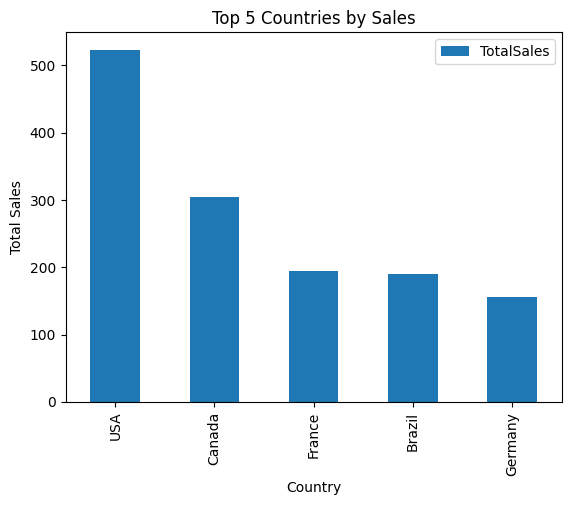

In [27]:
from langchain import hub
from langchain.agents import create_structured_chat_agent

llm = ChatOpenAI(model="gpt-4o-mini")

prompt = hub.pull("hwchase17/structured-chat-agent")

agent = create_structured_chat_agent(
    llm, tools, prompt
)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True
)
agent_executor.invoke({"input": "Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요."})